In [1]:
import pickle
from zipfile import ZipFile
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

In [3]:
# with ZipFile('data/9_way_dataset.zip', 'r') as zip:
#     zip.printdir()
#     # zip.extractall(path='/home/jipe/E208-Final-Project/data')
#     zip.extractall()

# with ZipFile('data/100_way_dataset.zip', 'r') as zip:
#     zip.printdir()
#     # zip.extractall(path='/home/jipe/E208-Final-Project/data')
#     zip.extractall()

In [5]:
with open('data/9_way_dataset.pkl', 'rb') as f:
    data = pickle.load(f)

In [6]:
images = data[0] + data[2] + data[4]
labels = data[1] + data[3] + data[5]

# pad images
images = [np.append(img, np.zeros((64, 2)), axis=1) for img in images]

In [7]:
len(labels)

40005

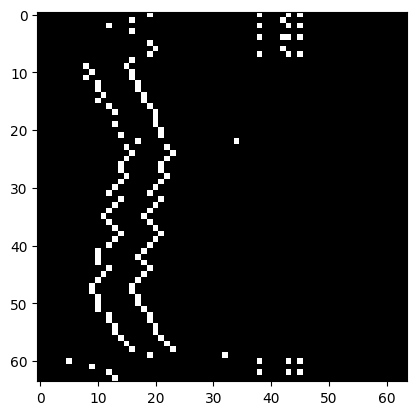

In [8]:
plt.imshow(images[0], cmap=cm.Greys_r)
plt.show()

In [9]:
images[0].shape

(64, 64)

In [11]:
from sklearn.preprocessing import LabelEncoder
import torch

# Assuming labels is a list of string labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Now you can convert your labels to a tensor
labels_tensor = torch.tensor(labels_encoded)

In [12]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx][None, :, :]
        return self.images[idx], self.labels[idx]

# Convert to PyTorch tensors
images_tensor = torch.Tensor(images)
images_tensor = torch.stack([torch.Tensor(img[np.newaxis, ...]) for img in images])
# labels_tensor = torch.Tensor(labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(images_tensor, labels_tensor, test_size=0.2)

# Create datasets
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

/tmp/ipykernel_134033/1356278186.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  images_tensor = torch.Tensor(images)


In [13]:
images_tensor.size()

torch.Size([40005, 1, 64, 64])

In [99]:
# import torchvision.models as models
# import torch.nn as nn

# def create_resnet_model(model_name, num_classes=9):
#     # Load a pre-trained ResNet
#     model = getattr(models, model_name)(pretrained=True)

#     # Freeze all layers
#     for param in model.parameters():
#         param.requires_grad = False

#     # Replace the last layer
#     num_ftrs = model.fc.in_features
#     model.fc = nn.Linear(num_ftrs, num_classes)

#     return model

# # Example
# model_resnet18 = create_resnet_model('resnet18')


In [16]:
import torchvision.models as models
import torch.nn as nn

def create_resnet_model(model_name, num_classes=9):
    # Load a pre-trained ResNet
    model = getattr(models, model_name)(pretrained=False)

    # Change the first convolutional layer to accept single-channel input
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # Freeze all layers
    # for param in model.parameters():
    #     param.requires_grad = True

    # Replace the last layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model


In [17]:
from torch import optim

In [21]:
# Example parameters
learning_rate = 0.002
num_epochs = 5

# Choose a model
# model = model_resnet18  # make sure this is defined as per the previous steps
model = create_resnet_model('resnet18')

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# Training and Validation loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(running_loss / len(test_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%")

100%|██████████| 126/126 [00:00<00:00, 213.22it/s]


Epoch [1/5], Train Loss: 2.1303, Train Accuracy: 18.39%, Validation Loss: 2.1252, Validation Accuracy: 19.66%


100%|██████████| 126/126 [00:00<00:00, 195.63it/s]


Epoch [2/5], Train Loss: 2.0452, Train Accuracy: 22.69%, Validation Loss: 2.0985, Validation Accuracy: 18.71%


100%|██████████| 126/126 [00:00<00:00, 179.04it/s]


Epoch [3/5], Train Loss: 2.0210, Train Accuracy: 24.25%, Validation Loss: 2.0328, Validation Accuracy: 23.46%


100%|██████████| 126/126 [00:00<00:00, 178.68it/s]


Epoch [4/5], Train Loss: 2.0082, Train Accuracy: 24.96%, Validation Loss: 2.0907, Validation Accuracy: 20.85%


100%|██████████| 126/126 [00:00<00:00, 179.13it/s]

Epoch [5/5], Train Loss: 2.0002, Train Accuracy: 25.47%, Validation Loss: 2.0982, Validation Accuracy: 21.78%
